In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pingouin import ttest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    roc_curve,
    auc,
    log_loss,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
import optuna

In [2]:
df_fruits = pd.read_csv("datasets/fruits_quality.csv")

## Exploratory Data Analysis


In [3]:
df_fruits.head(10)

a_id      size    weight  sweetness  crunchiness  juiciness  ripeness  \
0     0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1     1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2     2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3     3 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4     4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   
5     5 -3.425400 -1.409082  -1.913511    -0.555775  -3.853071  1.914616   
6     6  1.331606  1.635956   0.875974    -1.677798   3.106344 -1.847417   
7     7 -1.995462 -0.428958   1.530644    -0.742972   0.158834  0.974438   
8     8 -3.867632 -3.734514   0.986429    -1.207655   2.292873  4.080921   
9     9 -0.727983 -0.442820  -4.092223     0.597513   0.393714  1.620857   

    acidity quality  
0 -0.491590    good  
1 -0.722809    good  
2  2.621636     bad  
3  0.790723    good  
4  0.501984    good  
5 -2.981523     bad  
6  2.414171    good  
7 -1.470125    good  
8 -4.871905     bad  
9  2.185608     bad

In [4]:
df_fruits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   a_id         4000 non-null   int64  
 1   size         4000 non-null   float64
 2   weight       4000 non-null   float64
 3   sweetness    4000 non-null   float64
 4   crunchiness  4000 non-null   float64
 5   juiciness    4000 non-null   float64
 6   ripeness     4000 non-null   float64
 7   acidity      4000 non-null   float64
 8   quality      4000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 281.4+ KB


In [5]:
px.bar(
    df_fruits.value_counts("quality") / len(df_fruits) * 100,
    title="Quality distribution",
)

In [6]:
# Transform the "quality" column to a binary one
df_fruits["quality"] = df_fruits["quality"].map({"good": 1, "bad": 0})

In [7]:
# Drop the "a_id" column as it is not useful
df_fruits.drop(columns=["a_id"], axis=1, inplace=True)

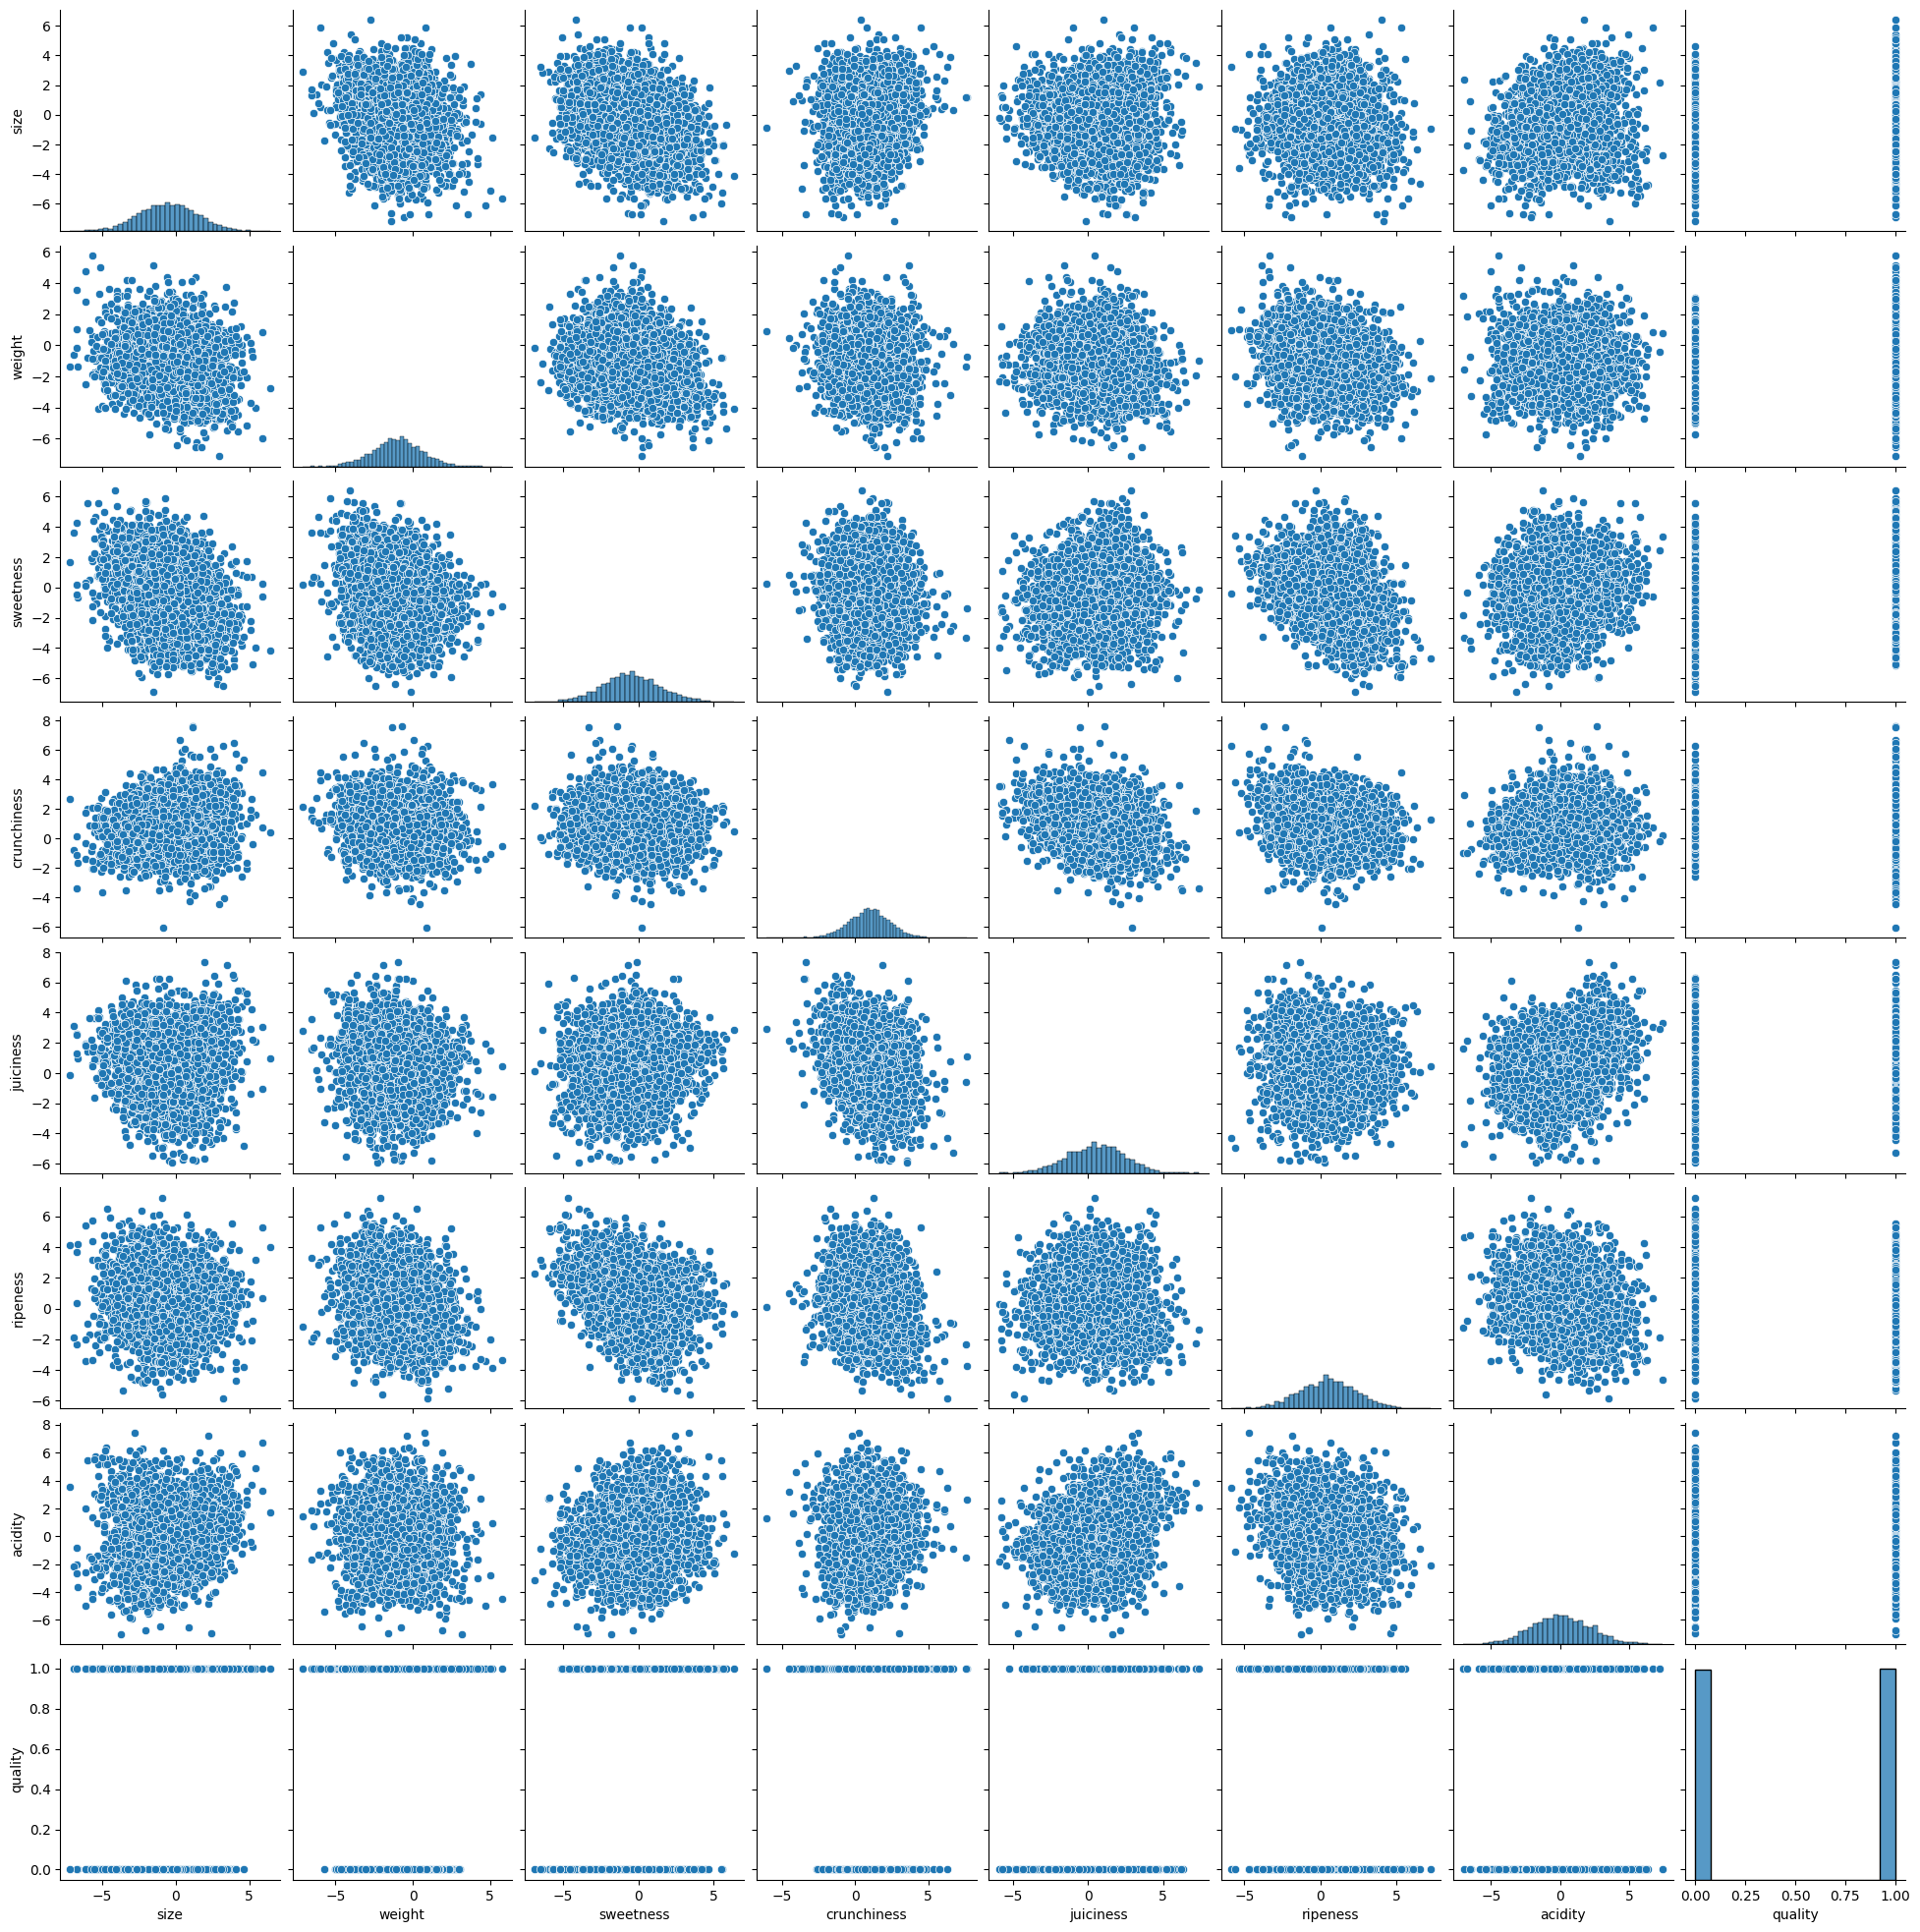

In [8]:
sns.pairplot(df_fruits, diag_kind="hist")

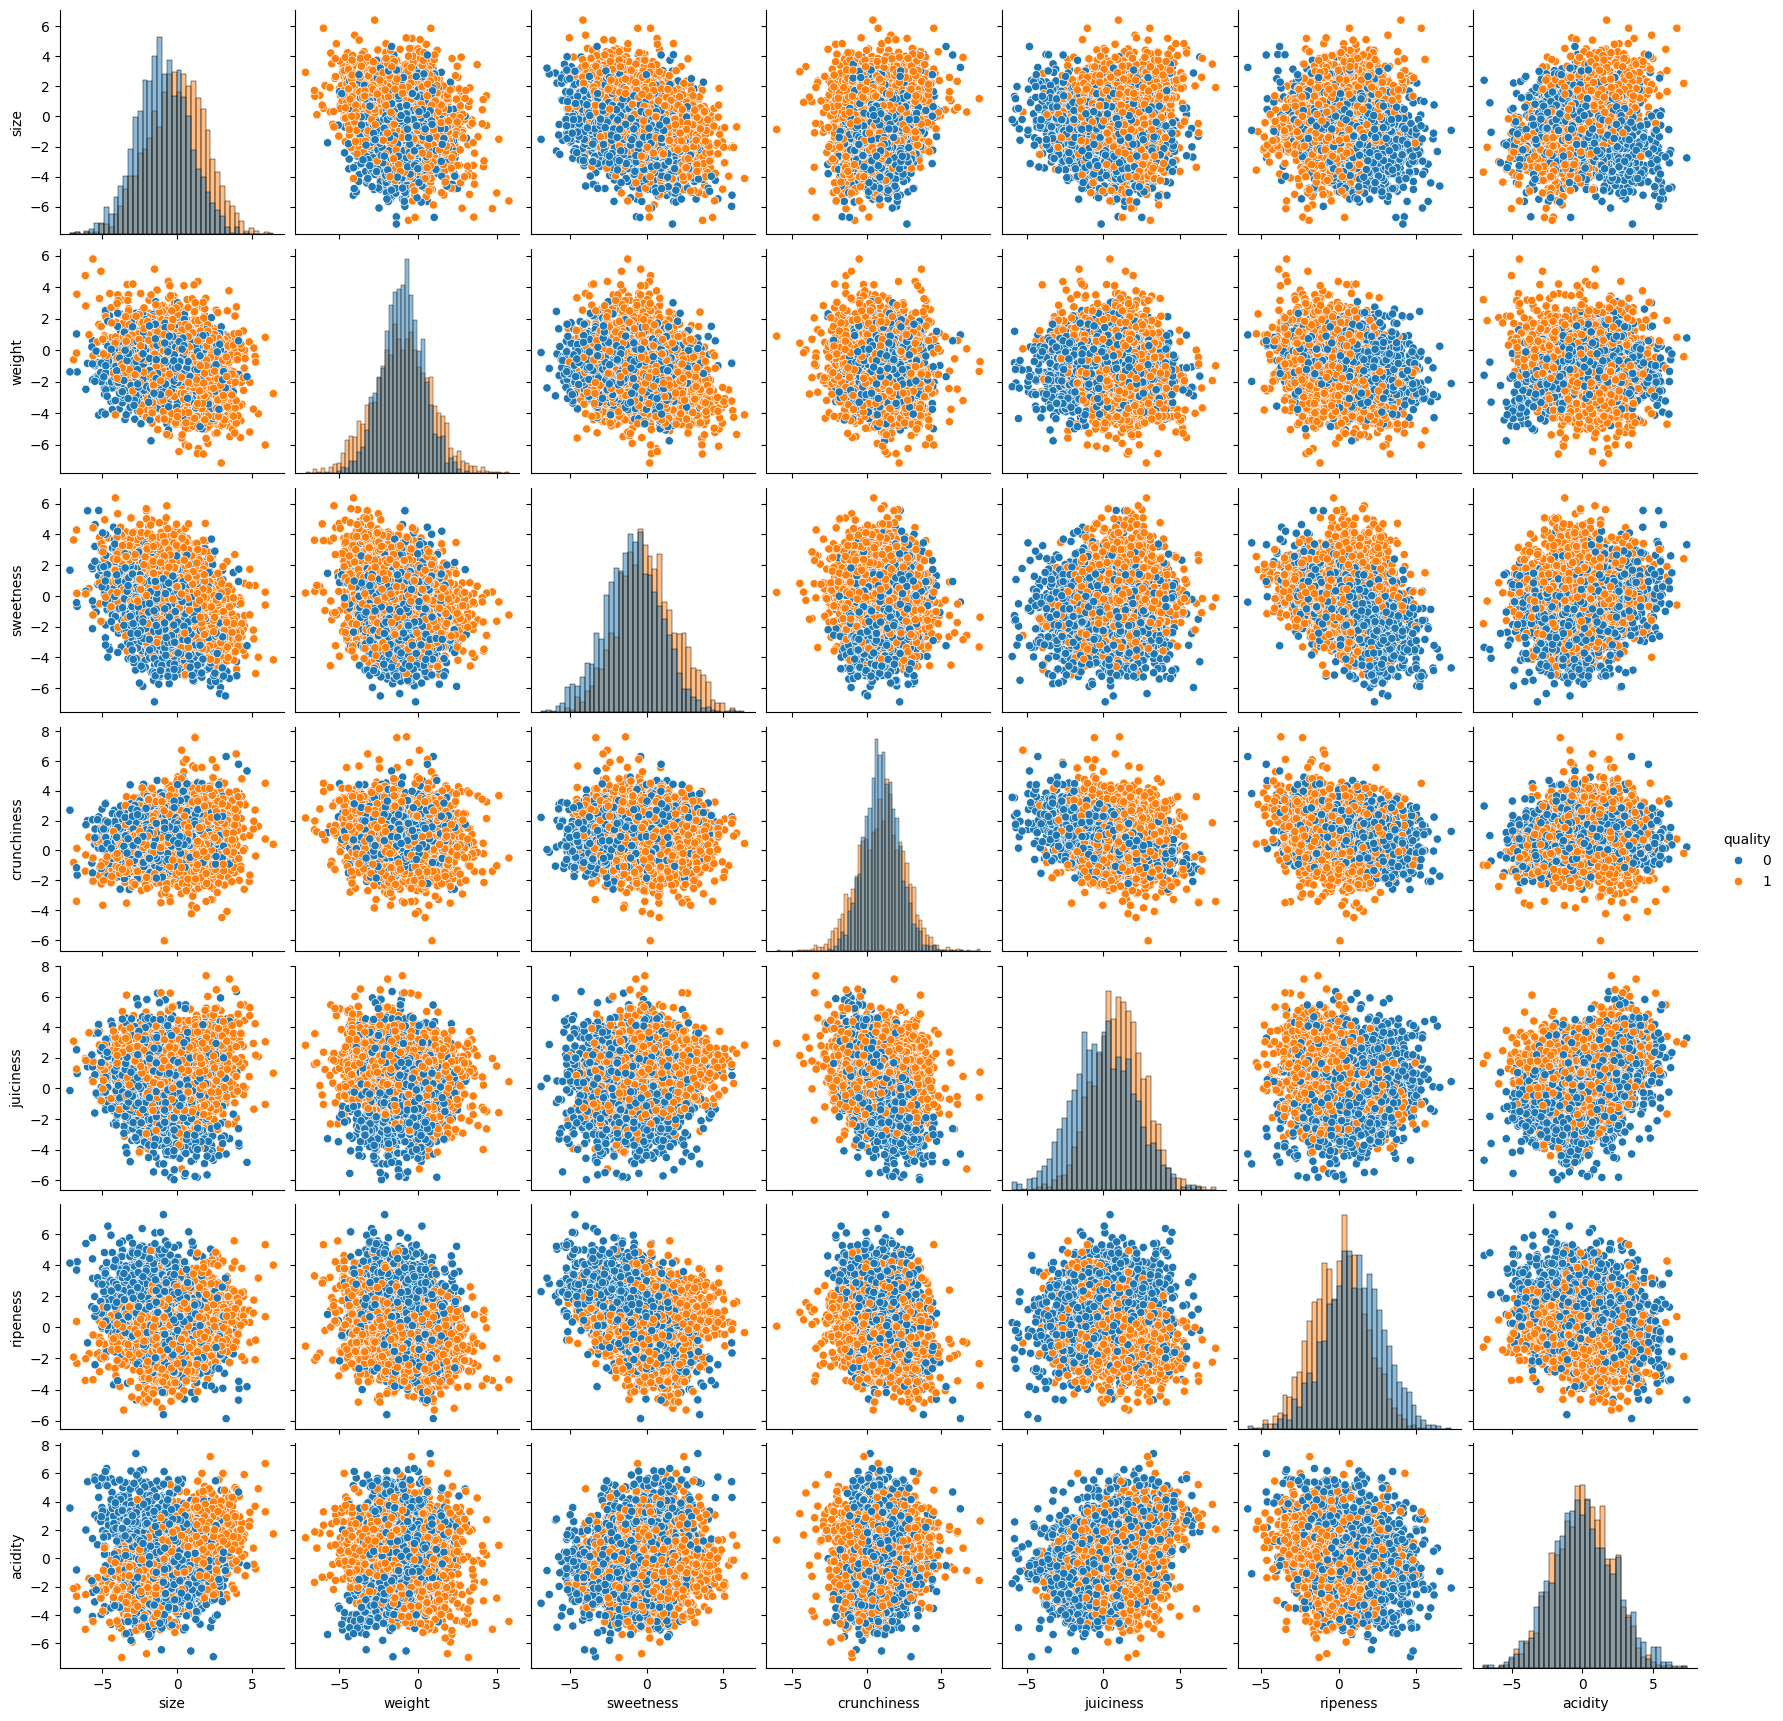

In [9]:
sns.pairplot(df_fruits, diag_kind="hist", hue="quality")

In [10]:
px.box(df_fruits, x="quality", y="weight", color="quality", title="Weight distribution")

In [11]:
px.box(
    df_fruits,
    x="quality",
    y="sweetness",
    color="quality",
    title="Sweetness distribution",
)

In [12]:
px.box(
    df_fruits,
    x="quality",
    y="size",
    color="quality",
    title="Size distribution",
)

In [13]:
# T-Student test is used to compare the means of two groups of samples to check if they are significantly different
# - H0: The means of the two groups are not significantly different
# - H1: The means of the two groups are significantly different
good_group = df_fruits[df_fruits["quality"] == 1]
bad_group = df_fruits[df_fruits["quality"] == 0]

ttest(good_group["weight"], bad_group["weight"], paired=False)

T          dof alternative     p-val         CI95%   cohen-d  \
T-test  0.089906  3599.742464   two-sided  0.928367  [-0.09, 0.1]  0.002841   

         BF10     power  
T-test  0.036  0.050925

In [14]:
ttest(good_group["sweetness"], bad_group["sweetness"], paired=False)

T          dof alternative         p-val         CI95%  \
T-test  16.396437  3995.125489   two-sided  1.590329e-58  [0.86, 1.09]   

        cohen-d       BF10  power  
T-test  0.51847  7.576e+54    1.0

In [15]:
ttest(good_group["size"], bad_group["size"], paired=False)

T          dof alternative         p-val         CI95%  \
T-test  15.912978  3951.450727   two-sided  2.602204e-55  [0.82, 1.06]   

        cohen-d       BF10  power  
T-test   0.5031  5.053e+51    1.0

In [16]:
corr_matrix = df_fruits.corr()
corr_matrix

size    weight  sweetness  crunchiness  juiciness  ripeness  \
size         1.000000 -0.170702  -0.324680     0.169868  -0.018892 -0.134773   
weight      -0.170702  1.000000  -0.154246    -0.095882  -0.092263 -0.243824   
sweetness   -0.324680 -0.154246   1.000000    -0.037552   0.095882 -0.273800   
crunchiness  0.169868 -0.095882  -0.037552     1.000000  -0.259607 -0.201982   
juiciness   -0.018892 -0.092263   0.095882    -0.259607   1.000000 -0.097144   
ripeness    -0.134773 -0.243824  -0.273800    -0.201982  -0.097144  1.000000   
acidity      0.196218  0.016414   0.085999     0.069943   0.248714 -0.202669   
quality      0.244007  0.001421   0.250998    -0.012376   0.260223 -0.264315   

              acidity   quality  
size         0.196218  0.244007  
weight       0.016414  0.001421  
sweetness    0.085999  0.250998  
crunchiness  0.069943 -0.012376  
juiciness    0.248714  0.260223  
ripeness    -0.202669 -0.264315  
acidity      1.000000 -0.007697  
quality     -0.007697  1.000000

In [17]:
fig = go.Figure(
    go.Heatmap(
        x=corr_matrix.columns,
        y=corr_matrix.index,
        z=np.array(corr_matrix),
        text=corr_matrix.values,
        texttemplate="%{text:.2f}",
        colorscale="RdBu",
        zmin=-1,
        zmax=1,
    )
)
fig.show()

## Training the baseline model


In [18]:
X = df_fruits.drop(columns=["quality"])
y = df_fruits["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=51
)

In [19]:
# "liblinear" is better for small datasets, while "lbfgs" is better for large ones.
baseline_model = LogisticRegression(solver="liblinear")

In [20]:
baseline_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

### Metrics


In [21]:
y_pred = baseline_model.predict(X_test)
y_pred[0:10]

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 1])

In [22]:
# The decision function returns the confidence of the model for each class (score)
y_decision = baseline_model.decision_function(X_test)
y_decision[0:10]

array([-0.62262518,  0.03737776,  0.24573024, -2.03945457, -1.25474302,
        0.71046554, -0.76034815,  0.60454646,  1.30670325,  2.04157675])

In [23]:
# The predict_proba function returns the probability of the model for each class
y_prob = baseline_model.predict_proba(X_test)
y_prob[0:10]

array([[0.65081537, 0.34918463],
       [0.49065665, 0.50934335],
       [0.43887471, 0.56112529],
       [0.88487772, 0.11512228],
       [0.77811982, 0.22188018],
       [0.32949598, 0.67050402],
       [0.68142932, 0.31857068],
       [0.35330422, 0.64669578],
       [0.21303903, 0.78696097],
       [0.11490627, 0.88509373]])

In [24]:
# Return values from ROC curve:
# - TPR: True Positive Rate (Recall)
# - FPR: False Positive Rate
# - Thresholds used to calculate TPR and FPR
fpr, tpr, thresholds = roc_curve(y_test, y_decision)

In [25]:
# Calculate AUC (AreaUnderCurve) based on the ROC curve
auc_score = auc(fpr, tpr)
auc_score

np.float64(0.8414568425263345)

In [26]:
# Plot ROC curve and AUC
fig = px.area(
    x=fpr,
    y=tpr,
    title=f"ROC Curve (AUC={auc_score:.4f})",
    labels={"x": "False Positive Rate", "y": "True Positive Rate"},
    width=600,
    height=600,
)
fig.add_shape(type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain="domain")
fig.show()

In [27]:
# Present the importance of each feature in the model
importance = np.abs(baseline_model.coef_)

print("Feature importance:")
for i, feature in enumerate(baseline_model.feature_names_in_):
    print(f"- {feature}: {importance[0][i]:.4f}")

Feature importance:
- size: 0.6050
- weight: 0.2502
- sweetness: 0.5489
- crunchiness: 0.0236
- juiciness: 0.4355
- ripeness: 0.1246
- acidity: 0.2773


In [28]:
# F1 score is the harmonic mean of precision and recall. It is a better metric than accuracy when the classes are imbalanced.
# The F1 score is a value between 0 and 1, where 1 is the best value.
baseline_f1_score = f1_score(y_test, y_pred)
print(f"F1 score: {baseline_f1_score:.4f}")

F1 score: 0.7788


In [29]:
log_loss(y_test, y_pred)

8.019712879078565

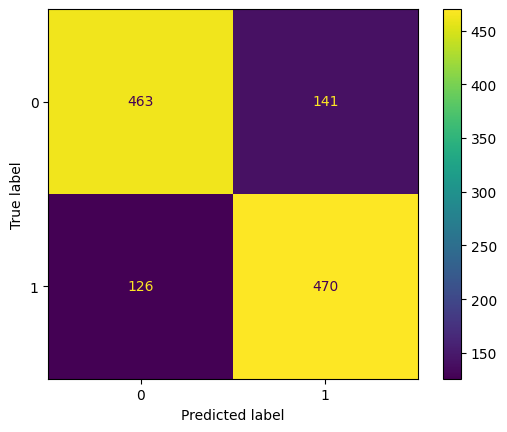

In [30]:
baseline_confusion_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=baseline_confusion_matrix).plot()

## Optimizing the model

#### Hyperparameters:

- **penalty:** Regularization term (l1 or l2). It is used to prevent overfitting.
- **C:** Inverse of regularization strength. Smaller values specify stronger regularization.


In [31]:
# Optuna is a hyperparameter optimization framework. It can be used to find the best hyperparameters for a model.
# The objective function is used to optimize the hyperparameters of the model.
def objective(trial: optuna.Trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    C = trial.suggest_categorical("C", [0.01, 0.1, 1, 10, 100])

    model = LogisticRegression(solver="liblinear", penalty=penalty, C=C)
    model.fit(X_train, y_train)

    # Predict the test set
    y_pred = model.predict(X_test)

    # Calculate the AUC score
    y_decision = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_decision)
    auc_score = auc(fpr, tpr)

    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred, average="macro")

    # Calculate the BCE loss (Binary Cross-Entropy)
    bce = log_loss(y_test, y_pred)

    return auc_score, f1, bce

In [32]:
search_space = {"penalty": ["l1", "l2"], "C": [0.01, 0.1, 1, 10, 100]}
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(
    directions=["maximize", "maximize", "minimize"],
    sampler=sampler,
)
study.optimize(objective)

[I 2024-09-10 07:55:06,804] A new study created in memory with name: no-name-1ac1f38d-6710-4791-80aa-a3ec402a773f
[I 2024-09-10 07:55:06,811] Trial 0 finished with values: [0.8408568158584826, 0.7758257051802457, 8.079785634727095] and parameters: {'penalty': 'l1', 'C': 0.1}.
[I 2024-09-10 07:55:06,841] Trial 1 finished with values: [0.8414207298102138, 0.7774924285618052, 8.019712879078565] and parameters: {'penalty': 'l1', 'C': 100}.
[I 2024-09-10 07:55:06,849] Trial 2 finished with values: [0.8413985066002934, 0.7766610831937465, 8.04974925690283] and parameters: {'penalty': 'l1', 'C': 1}.
[I 2024-09-10 07:55:06,856] Trial 3 finished with values: [0.8414207298102137, 0.7774924285618052, 8.019712879078565] and parameters: {'penalty': 'l2', 'C': 100}.
[I 2024-09-10 07:55:06,863] Trial 4 finished with values: [0.8383150362238322, 0.7657746143303981, 8.440222168618266] and parameters: {'penalty': 'l2', 'C': 0.01}.
[I 2024-09-10 07:55:06,868] Trial 5 finished with values: [0.841429063513

In [33]:
best_trial = max(study.best_trials, key=lambda trial: trial.values[1])
print("Best hyperparameters:")
print(f"- Penalty: {best_trial.params['penalty']}")
print(f"- C: {best_trial.params['C']}")
print(f"- AUC: {best_trial.values[0]:.4f}")
print(f"- F1: {best_trial.values[1]:.4f}")
print(f"- BCE: {best_trial.values[2]:.4f}")

Best hyperparameters:
- Penalty: l2
- C: 0.1
- AUC: 0.8412
- F1: 0.7775
- BCE: 8.0197


In [34]:
fig = optuna.visualization.plot_pareto_front(study)
fig.show()

In [35]:
# Compare the baseline model with the best model found by Optuna
print(f"AUC: Baseline={auc_score:.4f}, Best={best_trial.values[0]:.4f}")
print(f"F1: Baseline={baseline_f1_score:.4f}, Best={best_trial.values[1]:.4f}")
print(f"BCE: Baseline={log_loss(y_test, y_pred):.4f}, Best={best_trial.values[2]:.4f}")

AUC: Baseline=0.8415, Best=0.8412
F1: Baseline=0.7788, Best=0.7775
BCE: Baseline=8.0197, Best=8.0197


## Verify metrics with different thresholds


In [38]:
thresholds_list = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
thresholds_results = {
    "case": ["baseline", "optuna"],
    "result": [baseline_f1_score, best_trial.values[1]],
}

for threshold in thresholds_list:
    y_pred_threshold = (baseline_model.predict_proba(X_test)[:, 1] >= threshold).astype(
        int
    )
    f1_threshold = f1_score(y_test, y_pred_threshold)
    thresholds_results["case"].append(str(threshold))
    thresholds_results["result"].append(f1_threshold)

In [39]:
df_thresholds = pd.DataFrame(thresholds_results)
df_thresholds

case    result
0   baseline  0.778790
1     optuna  0.777500
2       0.55  0.747157
3        0.6  0.726606
4       0.65  0.677196
5        0.7  0.623158
6       0.75  0.566251
7        0.8  0.492044
8       0.85  0.379172
9        0.9  0.197309
10      0.95  0.052033

In [40]:
px.line(
    df_thresholds,
    x="case",
    y="result",
    title="F1 score for different thresholds",
    labels={"result": "F1 score", "case": "Threshold"},
)

## Saving the model


In [41]:
import joblib
import os

os.makedirs("models", exist_ok=True)
joblib.dump(baseline_model, "models/fruit_quality_model.pkl")

['models/fruit_quality_model.pkl']